# Density Based Spatial Clustering of Applications with Noise

In [ ]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
     - 149.9MB 501kB/s
     |████████████████████████████████| 6.6MB 3.1MB/s 
     |████████████████████████████████| 225kB 34.0MB/s 
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759606 sha256=821fd3f84f74b6aaa380df0752b76df4cfb9f9c5fa92c14acabf85eea196d2a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-snaqsomm/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-none-any.whl 

In [ ]:
import numpy as np 
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Check the Matplotlib Version 
print ("Matplotlib Version", matplotlib.__version__)

Matplotlib Version 3.2.2


In [ ]:
import pandas as pd

weather_df = pd.read_csv('weather-stations.csv')
print ("Shape of the DataFrame: ", weather_df.shape)
weather_df.head(3) 

Shape of the DataFrame:  (1341, 25)


,Stn_Name,Lat,Long,Prov,Tm,DwTm,D,Tx,DwTx,Tn,DwTn,S,DwS,S%N,P,DwP,P%N,S_G,Pd,BS,DwBS,BS%,HDD,CDD,Stn_No
0,CHEMAINUS,48.935,-123.742,BC,8.2,0.0,NaN,13.5,0.0,1.0,0.0,0.0,0.0,NaN,178.8,0.0,NaN,0.0,12.0,NaN,NaN,NaN,273.3,0.0,1011500
1,COWICHAN LAKE FORESTRY,48.824,-124.133,BC,7.0,0.0,3.0,15.0,0.0,-3.0,0.0,0.0,0.0,0.0,258.6,0.0,104.0,0.0,12.0,NaN,NaN,NaN,307.0,0.0,1012040
2,LAKE COWICHAN,48.829,-124.052,BC,6.8,13.0,2.8,16.0,9.0,-2.5,9.0,0.0,9.0,NaN,264.6,9.0,NaN,NaN,11.0,NaN,NaN,NaN,168.1,0.0,1012055


So there are 25 columns and now we need to learn more about the Columns, The names that are difficult to guess 
* Stn_Name === Station Name
* Prov     === Province
* Tm       === Mean Temperature (°C)
* Tn       === Lowest Monthly Minimum Temperature 
* Tx       === Highest Monthly Maximum Temperature 
* DwTm     === Days Without Valid Mean Temperature
* DwTx     === Days Without Valid Maximum Temperature
* DwTn     === Days Without Valid Minimum Temperature
* D        === Mean Temperature Difference from Normal
* S        === Snowfall (cm)
* DwS      === Days Without Snowfall
* S%N      === Percent of Normal Snowfall
* P        === Total Precipitation (mm)
* DwP      === Days Without Valid Precipitation
* P%N      === Percent of Normal Precipitation
* Pd       === No. of days with precipitation 1mm or More 
* BS       === Bright Sunshine days
* DwBS     === Days Without valid Bright Sunshine
* BS%      === Percent of Normal Bright Sunshine
* HDD      === Degree Days Below $18^{\circ}$C 
* CDD      === Degree Days Above $18^{\circ}$C
* Stn_No   === Station Number; Climate Station Identifier (1st 3 Digits==Indicate drainage basin, Last 4 Digits Sorting Alphabetically)



We can see that there are some columns that contains NaN values. One of the importnat features is Mean temperature (Tm), so we drop the rows that contain NaN values in Tm column   

In [ ]:
# check the nan values in the dataframe 
weather_df.isna().sum()

Stn_Name       0
Lat            0
Long           0
Prov           0
Tm            85
DwTm          85
D            984
Tx            81
DwTx          81
Tn            81
DwTn          81
S            755
DwS          755
S%N         1143
P            114
DwP          114
P%N         1132
S_G          543
Pd           114
BS          1341
DwBS        1341
BS%         1341
HDD           85
CDD           85
Stn_No         0
dtype: int64

In [ ]:
weather_df.dropna(subset=['Tm', 'Tx', 'Tn'], inplace=True)
print ("After Dropping Rows that contains NaN on Mean, Max, Min Temperature Column: ", weather_df.shape)

After Dropping Rows that contains NaN on Mean, Max, Min Temperature Column:  (1255, 25)


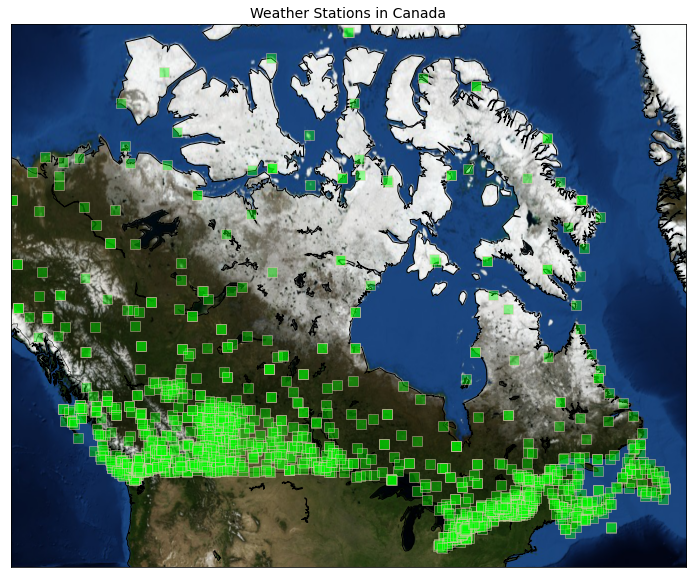

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib
from PIL import Image
import matplotlib.pyplot as plt
#print (matplotlib.__version__)
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)


llon=-140
ulon=-50
llat=40
ulat=75

# selecting the boundaries of the map from lattitude and longitude 

weather_df = weather_df[(weather_df['Long'] > llon) & (weather_df['Long'] < ulon) & 
                        (weather_df['Lat'] > llat) &(weather_df['Lat'] < ulat)]



my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
my_map.drawlsmask(land_color='orange', ocean_color='skyblue')
#my_map.shadedrelief()
my_map.bluemarble()
# To collect data based on stations        

xs,ys = my_map(np.asarray(weather_df.Long), np.asarray(weather_df.Lat))
weather_df['xm']= xs.tolist()
weather_df['ym'] =ys.tolist()

#Visualization1
for index,row in weather_df.iterrows():
#   x,y = my_map(row.Long, row.Lat)
   my_map.plot(row.xm, row.ym,markerfacecolor ='lime',markeredgecolor='pink', marker='s', markersize= 10, alpha = 0.4)
#plt.text(x,y,stn)
plt.title("Weather Stations in Canada", fontsize=14)
plt.savefig("Canada_WS.png", dpi=300)
plt.show()

### Clustering Weather Stations Based on Mean, Maximum and Minimum Temperature. <br>

#### In the DataFrame the Variables are Tm, Tn, Tx.   <br> First we check the distribution of the temperatures to get an rough Idea. Find the maximum, minimum of these three features to get a rough idea.  

In [ ]:
print ("Minimum Mean temperature: ", weather_df['Tm'].min())
print ("Minimum Max Temperature: ", weather_df['Tx'].min())
print ("Maximun Min Temperature: ", weather_df['Tn'].max())

Minimum Mean temperature:  -37.0
Minimum Max Temperature:  -28.9
Maximun Min Temperature:  5.3


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


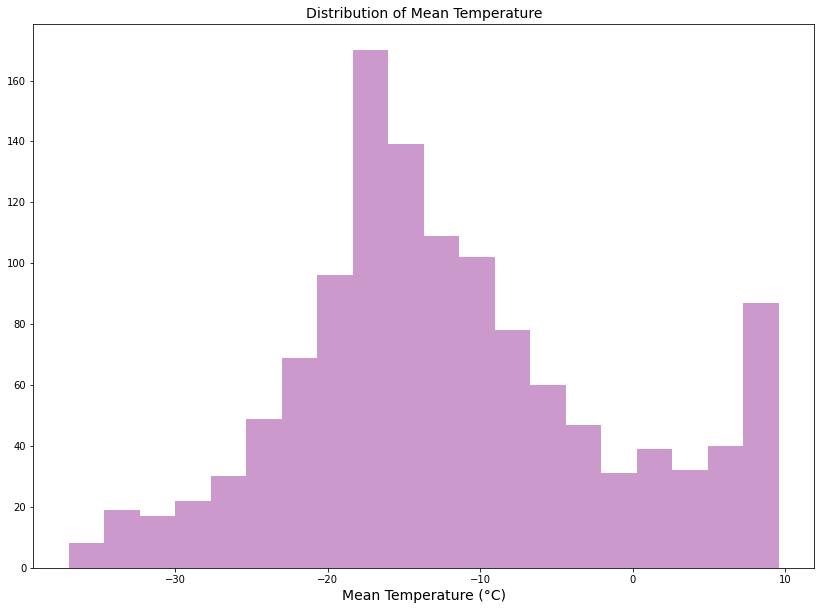

In [ ]:
sns.distplot(weather_df['Tm'], color='purple', kde=False)
plt.xlabel('Mean Temperature (°C)', fontsize=14)
plt.title("Distribution of Mean Temperature", fontsize=14)
plt.savefig("Dist_of_Mean_Temp.png", dpi=200)
plt.show()

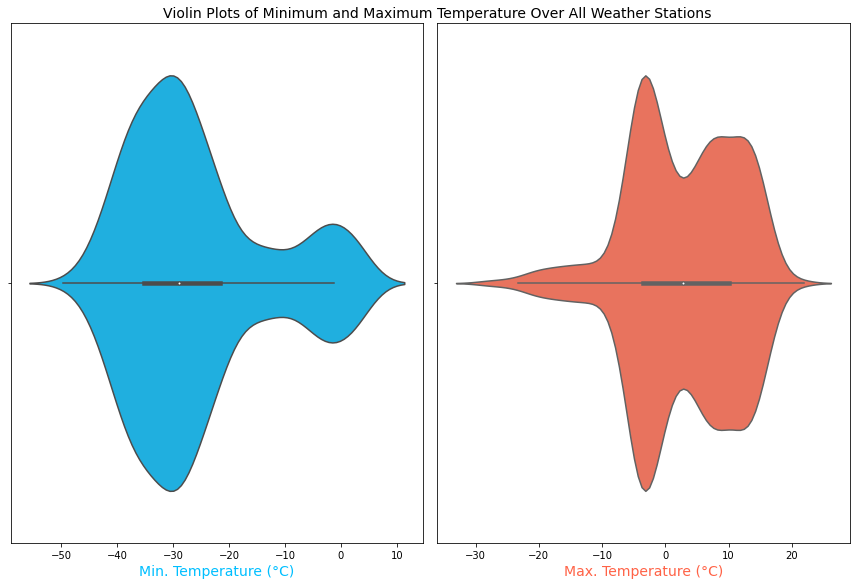

In [ ]:
# Violin Plots of Minimum and Maximum Temperature
fig = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x=weather_df["Tn"], color='deepskyblue')
plt.xlabel("Min. Temperature (°C)", fontsize=14, color='deepskyblue')
plt.subplot(1,2,2)
sns.violinplot(x=weather_df["Tx"], color='tomato')
plt.xlabel("Max. Temperature (°C)", fontsize=14, color='tomato')
plt.tight_layout()
plt.title("Violin Plots of Minimum and Maximum Temperature Over All Weather Stations", fontsize=14, x=-0.0)
plt.savefig("Violin_Plots_Min_Max_Temp.png", dpi=200)
plt.show()

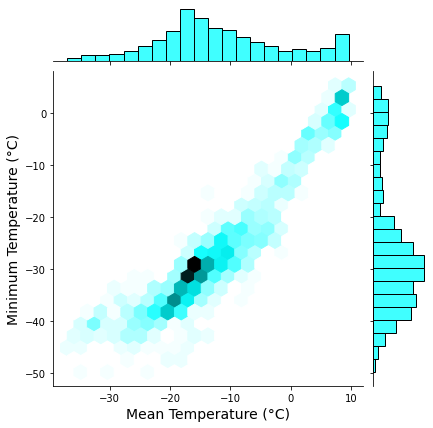

In [ ]:
# Joint Plot of Mean Temperature and Minimum Temperature
g=sns.jointplot(x=weather_df['Tm'], y=weather_df['Tn'], kind='hex', color='cyan')
g.set_axis_labels("Mean Temperature (°C)","Minimum Temperature (°C)", fontsize=14)
plt.savefig("Hex_Tm_Tn.png", dpi=200)
plt.show()

### Proceed To Clustering using DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
weather_df_clus_temp = weather_df[["Tm", "Tx", "Tn", "xm", "ym"]]
weather_df_clus_temp = StandardScaler().fit_transform(weather_df_clus_temp)

db = DBSCAN(eps=0.3, min_samples=10).fit(weather_df_clus_temp)
labels = db.labels_
print (labels[500:560])
weather_df["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels))

[ 4  4  4  4  4  4  4  4  4  3  4  3  4  3  4  4  4  4  4  4  4  4  4  4
  4  4 -1  4  4  4 -1  4 -1  3 -1  4 -1  3  3  3  3  3  3  3  3  3  3  3
 -1 -1  3  3  3  3 -1  3  3  3  3  3]


In [ ]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7}

#### Plot the Clusters in the Map. 

Cluster 0, Average Mean Temp: 6.240677966101697
Cluster 1, Average Mean Temp: -0.5523809523809524
Cluster 2, Average Mean Temp: -3.244444444444445
Cluster 3, Average Mean Temp: -13.733725490196077
Cluster 4, Average Mean Temp: -4.153703703703704
Cluster 5, Average Mean Temp: -16.401294498381873
Cluster 6, Average Mean Temp: -10.08421052631579
Cluster 7, Average Mean Temp: -4.70625


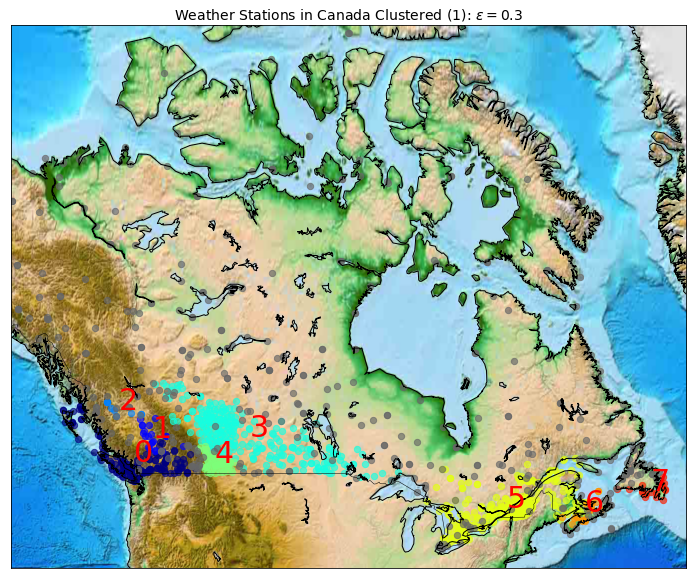

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
#my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.drawlsmask(land_color='orange', ocean_color='skyblue')
#my_map.shadedrelief()
#my_map.bluemarble()
#my_map.shadedrelief()
my_map.etopo()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = weather_df[weather_df.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 40, alpha = 0.65)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=30, color='red',)
        print ("Cluster "+str(clust_number)+', Average Mean Temp: '+ str(np.mean(clust_set.Tm)))
plt.title(r"Weather Stations in Canada Clustered (1): $ \epsilon = 0.3$", fontsize=14)        
plt.savefig("etopo_cluster.png", dpi=300)        

## Repeat The Process One More Time Including Precipitation as Feature  

In [ ]:
# stop the SettingWithCopyWarning: 
pd.options.mode.chained_assignment = None  # default='warn'
#

from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
weather_df_copy = weather_df.copy()
weather_df_clus_temp_P = weather_df_copy[["Tm", "Tx", "Tn", "xm", "ym", "P"]]

weather_df_clus_temp_P.dropna(subset=["Tm", "Tx", "Tn", "xm", "ym", "P"], inplace=True)
print ("After Dropping Rows that contains NaN on Precipitation Column: ", weather_df_clus_temp_P.shape)

print (weather_df_clus_temp_P.head(6))

After Dropping Rows that contains NaN on Precipitation Column:  (1136, 6)
    Tm    Tx   Tn            xm            ym      P
0  8.2  13.5  1.0  1.807806e+06  1.396332e+06  178.8
1  7.0  15.0 -3.0  1.764329e+06  1.377564e+06  258.6
2  6.8  16.0 -2.5  1.773336e+06  1.378409e+06  264.6
4  7.7  14.5 -1.0  1.809363e+06  1.362546e+06  168.4
5  8.8  13.1  1.9  1.841498e+06  1.311615e+06   81.0
6  8.9  13.5  2.0  1.826598e+06  1.404800e+06  110.0


In [ ]:
#print (weather_df_clus_temp.shape)
weather_df_clus_temp_P_arr = weather_df_clus_temp_P[["Tm", "Tx", "Tn", "xm", "ym", "P"]]
weather_df_clus_temp_P_arr = StandardScaler().fit_transform(weather_df_clus_temp_P_arr)

db_P = DBSCAN(eps=0.5, min_samples=10).fit(weather_df_clus_temp_P_arr)
# # create an array of zeroes of same size as db.labels_. db.labels_ is an array containing labels for 
labels_P = db_P.labels_
print(labels_P[500:560])
print (labels_P.dtype)
#print(np.isnan(labels_P).any())
weather_df_clus_temp_P["Clus_Db_"]=labels_P

[ 1  1  1 -1 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1 -1
 -1 -1  1 -1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1]
int64


In [ ]:
weather_df_clus_temp_P.head(6)

,Tm,Tx,Tn,xm,ym,P,Clus_Db_
0,8.2,13.5,1.0,1.807806e+06,1.396332e+06,178.8,0
1,7.0,15.0,-3.0,1.764329e+06,1.377564e+06,258.6,-1
2,6.8,16.0,-2.5,1.773336e+06,1.378409e+06,264.6,-1
4,7.7,14.5,-1.0,1.809363e+06,1.362546e+06,168.4,0
5,8.8,13.1,1.9,1.841498e+06,1.311615e+06,81.0,0
6,8.9,13.5,2.0,1.826598e+06,1.404800e+06,110.0,0


In [ ]:
realClusterNum_P=len(set(labels_P)) - (1 if -1 in labels_P else 0)
clusterNum_P = len(set(labels_P)) 


print (set(labels_P))

{0, 1, 2, 3, -1}


Cluster 0, Average Mean Temp: 7.680246913580246
Cluster 0, Average Mean Precipitation: 126.09999999999997
Cluster 1, Average Mean Temp: -12.53424283765348
Cluster 1, Average Mean Precipitation: 27.415006821282383
Cluster 2, Average Mean Temp: -26.14285714285714
Cluster 2, Average Mean Precipitation: 8.7
Cluster 3, Average Mean Temp: -10.406666666666668
Cluster 3, Average Mean Precipitation: 146.02333333333328


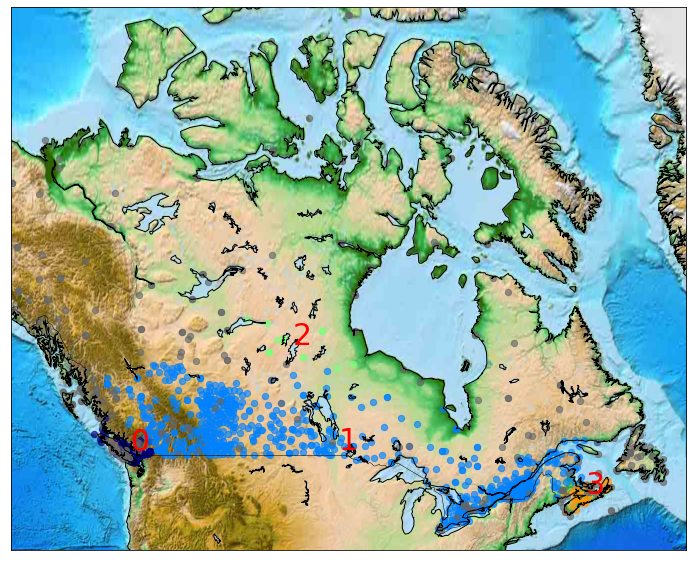

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (14,10)

my_map1 = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map1.drawcoastlines()
my_map1.drawcountries()
#my_map.drawmapboundary()
#my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map1.drawlsmask(land_color='orange', ocean_color='skyblue')
#my_map.shadedrelief()
#my_map.bluemarble()
#my_map.shadedrelief()
my_map1.etopo()

# To create a color map
colors1 = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum_P))



#Visualization1
for clust_number_P in set(labels_P):
    c=(([0.4,0.4,0.4]) if clust_number_P == -1 else colors1[np.int(clust_number_P)])
    clust_set_P = weather_df_clus_temp_P[weather_df_clus_temp_P.Clus_Db_ == clust_number_P]                    
    my_map.scatter(clust_set_P.xm, clust_set_P.ym, color =c,  marker='o', s= 40, alpha = 0.65)
    if clust_number_P != -1:
        cenx=np.mean(clust_set_P.xm) 
        ceny=np.mean(clust_set_P.ym) 
        plt.text(cenx,ceny,str(clust_number_P), fontsize=30, color='red',)
        print ("Cluster "+str(clust_number_P)+', Average Mean Temp: '+ str(np.mean(clust_set_P.Tm)))
        print ("Cluster "+str(clust_number_P)+', Average Mean Precipitation: '+ str(np.mean(clust_set_P.P)))
plt.savefig("etopo_cluster_preci.png", dpi=300)